# Homework 3

## Problem 1

Data:	
HJAndrews_peakflow_WS1_WS2_WS3.xlsx

For this problem, consider only differences between WS1 and WS2. These two watersheds are adjacent to each other, and we expect they experience the same storms leading to peak runoff. WS2 is the control, but WS1 was actively 100% clearcut from late 1962 to 1966. Here we want to test whether the difference in peak flows between WS1 and WS2 is statistically different in 4 periods (labeled Index12), where 1 indicates the control period pre-treatment, 2 indicates the period of active treatment, 3 indicates the first 15 years post-treatment (when the forest would start to recover), and 4 indicates longer than 15 years post-treatment. We want to know whether the four periods are statistically different from each other, and if so, which one or ones are statistically different from which other ones.

In [3]:
import numpy as np
import scipy.stats as st
from scipy.io import loadmat
import statistics as stats
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


In [4]:
df=pd.read_excel('HJAndrews_peakflow_WS1_WS2_WS3.xlsx')

In [77]:
df_hja

,year,WS1,WS2,WS3,I12,I23,Q12,Qlog12
2,1953,87.5495,96.0073,81.9364,1,1,-8.4578,-0.092220
3,1954,74.7993,60.2205,50.7975,1,1,14.5788,0.216796
4,1955,54.4041,40.5364,35.1773,1,1,13.8677,0.294239
5,1956,73.5548,69.7704,54.6327,1,1,3.7844,0.052821
6,1957,78.3552,71.5483,57.1218,1,1,6.8069,0.090880
7,1958,93.1119,97.0233,80.5141,1,1,-3.9114,-0.041149
8,1959,52.4738,42.5175,37.8696,1,1,9.9563,0.210398
9,1960,28.3958,26.5671,24.8654,1,2,1.8287,0.066568
10,1961,82.2412,74.52,61.719,1,2,7.7212,0.098589
11,1962,72.1579,55.4963,55.1915,1,2,16.6616,0.262540


In [22]:
#rearrage the dataset
df_hja=df[2:].copy()
df_hja.columns=['year','WS1','WS2','WS3','I12','I23']
df_hja.head()

,year,WS1,WS2,WS3,I12,I23
2,1953,87.5495,96.0073,81.9364,1,1
3,1954,74.7993,60.2205,50.7975,1,1
4,1955,54.4041,40.5364,35.1773,1,1
5,1956,73.5548,69.7704,54.6327,1,1
6,1957,78.3552,71.5483,57.1218,1,1


A) First, plot the timeseries of peakflow as a function of wateryear for both watershed 1 and watershed 2 on the same graph, with vertical dashed lines to indicate the different periods (put a vertical dashed line in 1963, in 1967, and in 1982).

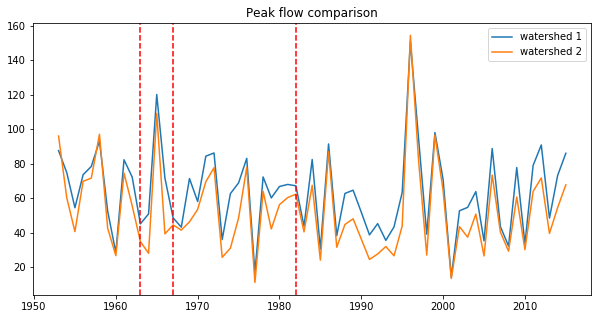

In [30]:
plt.figure(figsize=(10,5))

plt.plot(df_hja['year'],df_hja['WS1'],label='watershed 1')
plt.plot(df_hja['year'],df_hja['WS2'],label='watershed 2')
plt.axvline(1963,linestyle='--',color='red')
plt.axvline(1967,linestyle='--',color='red')
plt.axvline(1982,linestyle='--',color='red')
plt.title('Peak flow comparison')

plt.legend(loc='best')
plt.show()

B) It has been suggested that paired data such as this can be made to be closer to normally distributed by taking the log of each value before subtracting. Create two series: Q12=Peakflow1-Peakflow2; and Qlog12=log(Peakflow1)- log(Peakflow2); and make graphs to demonstrate which is closer to normally distributed. Given that we want to use an ANOVA analysis, <font color = 'red'>why is it important to do a transformation to get the data closer to normally distributed?

In [53]:
#Create columns with the Q12 and Qlog12
df_hja['Q12']=df_hja['WS1']-df_hja['WS2']
df_hja['Qlog12']=np.log(list(df_hja['WS1']))-np.log(list(df_hja['WS2']))
df_hja.head()

,year,WS1,WS2,WS3,I12,I23,Q12,Qlog12
2,1953,87.5495,96.0073,81.9364,1,1,-8.4578,-0.092220
3,1954,74.7993,60.2205,50.7975,1,1,14.5788,0.216796
4,1955,54.4041,40.5364,35.1773,1,1,13.8677,0.294239
5,1956,73.5548,69.7704,54.6327,1,1,3.7844,0.052821
6,1957,78.3552,71.5483,57.1218,1,1,6.8069,0.090880


In [84]:
def pdf_fn(data, nbins):
    counts, bins, patches = plt.hist(data, nbins)
    plt.close()
    width = bins[2]-bins[1]
    centers = bins + width/2
    centers_list = np.array(centers).tolist()
    # Then, remove the last number from the list.
    centers_list.remove(centers_list[len(centers_list)-1])
    areas = [c * width for c in counts]
    area_under_curve = sum(areas)
    fractions = [c / area_under_curve for c in counts]
    return centers_list, fractions

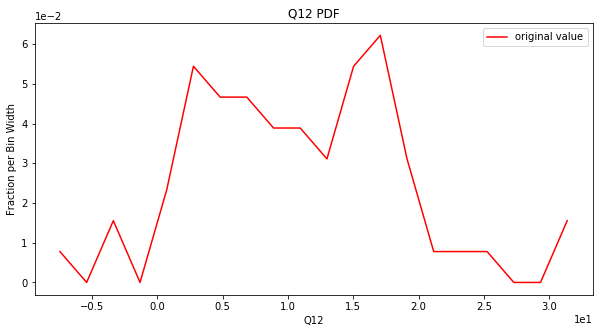

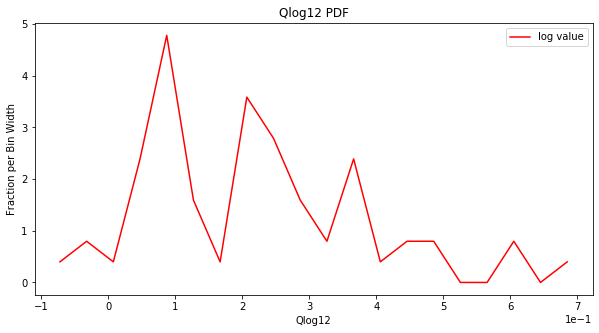

In [85]:
#Create the comparison plot
nbins = 20
#Generate data for the plots,_w for whole period, _b for before, _a for after
cl, frac = pdf_fn(list(df_hja['Q12']), nbins)
cl_log,frac_log = pdf_fn(list(df_hja['Qlog12']), nbins)

plt.figure(1,figsize=(10,5))

plt.plot(cl, frac,'r',linestyle='-',label='original value')
plt.xlabel('Q12')
plt.ylabel('Fraction per Bin Width')
plt.title('Q12 PDF')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(loc='best')

plt.figure(2,figsize=(10,5))

plt.plot(cl_log, frac_log,'r',linestyle='-',label='log value')
plt.xlabel('Qlog12')
plt.ylabel('Fraction per Bin Width')
plt.title('Qlog12 PDF')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(loc='best')


C) State the null and the alternative hypothesis for the question of whether the four periods are statistically different from each other. State the type I error (alpha value) that you are willing to accept.

    
## Based on the lecture notes in class and from the Portland state university website, we propose a null and alternative hypothesis.
𝐻0 : The means have the same central mean

𝐻1 : The means are different from each other

In this case, we perform a one way ANOVA to determine whether our null hypothesis ( 𝐻0 ) is true or not.

In this question the type I error(alpha value) = 0.05 is acceptable to me, which indicate the 95% confidence interval.

In [83]:
# stats f_oneway functions takes the groups as input and returns F and P-value
#fvalue, pvalue = st.f_oneway(df_hja['WS2'], df_hja['WS1'])
#print(fvalue, pvalue)

D) Perform an ANOVA test and discuss the results, related both to your hypothesis test listed above and to the more detailed question of which groups are statistically different from which other groups. Include graphs and/or tables that illustrate your results, and be sure to discuss what they mean. It's fine to use computer software here, but be sure that you understand what the code is doing and outputting.

重建表格，分为四个period然后重组数据做anova

In [75]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(df_hja.reset_index(), id_vars=['index'], value_vars=['WS2', 'WS1'])
# replace column names
d_melt.columns = ['index', 'treatments', 'value']
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

ValueError: operands could not be broadcast together with shapes (2,2) (126,126) 

In [74]:
# load packages
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=d_melt['value'], groups=d_melt['treatments'], alpha=0.05)
print(m_comp)

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

## Problem 2

USGS gaged streamflow records for the Columbia River at The Dalles, OR began in 1878 and continues to the present day (one of the longest continuous records in the U.S.). Peak flow records (based on peak stage values recorded by railroad workers), however, extend back even farther, to 1858. Using coincident peak flow records from 1879-1932 (a period with no major storage dams on the Columbia):

A) First, isolate the period of relevant overlap (1879-1932) and plot the timeseries. Create a regression model for annual flow using spring peak flow as an explanatory variable.

B) How much of the variance is explained by the resulting model?

C) Estimate the 95% confidence bounds for the annual flow estimates from 1858- 1877, and plot them with the central tendency (the prediction from the regression model).

D) Now create a non-parametric, quantile-based regression model using the same data.

E) Plot the predictions and residuals for the two different prediction models for the training period (1879-1932) and plot the model predictions for the pre-1878 data for the two different models. Is there a substantial difference between the two model formulations?